# Problem Set 5, Amol Surve

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:



Hello Friends,

For Problem Set 5, kindly use the following values for the 'random_state' parameter of train_test_split()

1. For Q 2.2, random_state = 0

2. For 4.1, random_state = 200

Setting the random state will ensure that the random split is consistent for the entire class. In other words, it makes our lives easier while grading!


In [141]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from  sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from  sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn


## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's likely [Oscar winner](http://www.rottentomatoes.com/m/the_revenant_2015/) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [142]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

#dropping null rows
reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]
#reviews.tail(4)
movies.head(5)

review = reviews.dropna(how = 'any')
movies = movies.dropna(how = 'any')

### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [143]:
#a list of unique reviews
uniqueQuotes=list(set(reviews.quote))
#printing the list count 
print "Number of unique reviews(Quotes) are %i"% len(uniqueQuotes) 

#a list of unique reviewers
uniqueCritics=list(set(reviews.critic))
#printing the list count
print "Number of unique reviewers(Critics) are %i"% len(uniqueCritics) 

#a list of unique movies in reviews dataset
uniqueMovies1=list(set(reviews.title))
#printing the list count
print "Number of unique movies in reviews dataset are %i"% len(uniqueMovies1) 

#a list of unique movies in movies dataset
uniqueMovies2=list(set(movies.title))
#printing the list count
print "Number of unique movies in movies dataset are %i"% len(uniqueMovies2) 

#a list of unique publications in reviews dataset
publications=list(set(reviews.publication))
#printing the list count
print "Number of unique publications in reviews dataset are %i"% len(publications) 

Number of unique reviews(Quotes) are 12814
Number of unique reviewers(Critics) are 541
Number of unique movies in reviews dataset are 1720
Number of unique movies in movies dataset are 8959
Number of unique publications in reviews dataset are 64


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

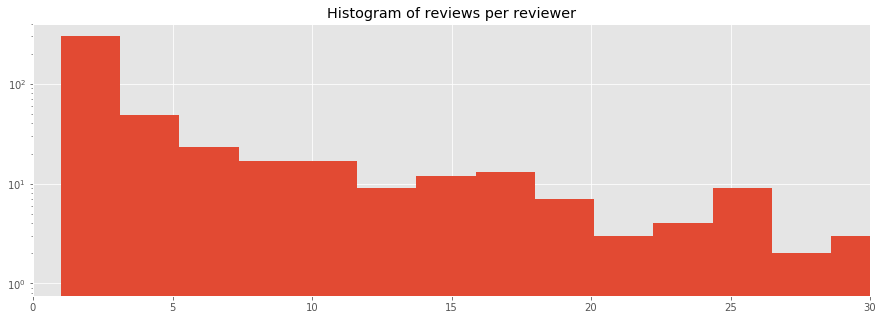

In [144]:
reviews_per_reviewer = reviews.groupby('critic').size()

plt.figure(figsize=(15,5))
plot = reviews_per_reviewer.hist(log = True, bins = 541)
plt.xlim(0, 30)
plt.title('Histogram of reviews per reviewer')
plt.show()

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [145]:

Top30critic = list(reviews.groupby('critic', as_index = False).size().sort_values(ascending = False)[0:30].index)

top30Data= reviews[reviews['critic'].isin(Top30critic)][['critic', 'publication', 'review_date']]

lastDate = top30Data.groupby(['critic','publication'], as_index = False)['review_date'].max()
firstDate = top30Data.groupby(['critic', 'publication'], as_index = False)['review_date'].min()

zoom_data = top30Data[['critic', 'publication']]


tableData = pd.merge(firstDate, lastDate, on = ['critic', 'publication'])
tableData.columns = ['critic', 'publication', 'review_date - first', 'review_date - last']
tableData


,critic,publication,review_date - first,review_date - last
0,Bosley Crowther,New York Times,2000-01-01 00:00:00,2008-05-06 00:00:00
1,Dave Kehr,Chicago Reader,2000-01-01 00:00:00,2013-11-06 00:00:00
2,Dave Kehr,Chicago Tribune,2013-02-20 00:00:00,2013-11-20 00:00:00
3,Dave Kehr,New York Daily News,2013-08-02 00:00:00,2013-10-22 00:00:00
4,Derek Adams,Time Out,2006-01-26 00:00:00,2009-10-04 00:00:00
5,Desson Thomson,Washington Post,2000-01-01 00:00:00,2012-10-08 00:00:00
6,Edward Guthmann,San Francisco Chronicle,2000-01-01 00:00:00,2003-04-04 00:00:00
7,Emanuel Levy,Variety,2000-01-01 00:00:00,2010-08-06 00:00:00
8,Geoff Andrew,Time Out,2005-08-11 00:00:00,2012-04-05 00:00:00
9,Hal Hinson,Washington Post,2000-01-01 00:00:00,2013-06-26 00:00:00


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

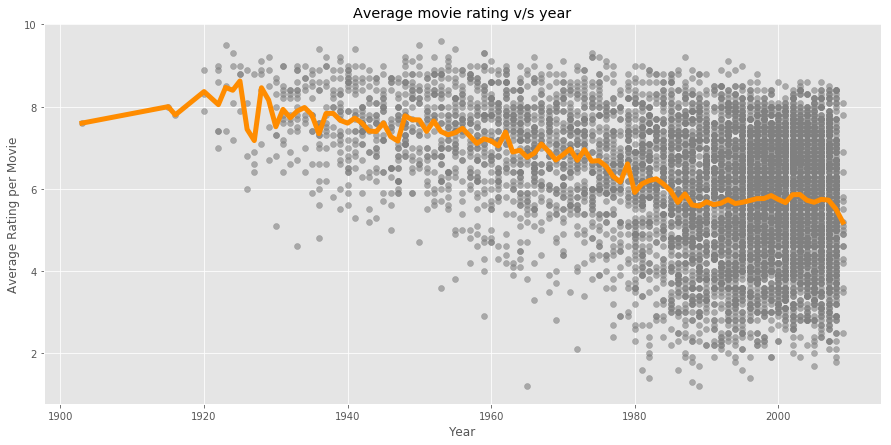

In [146]:
# enter your code here
movies['rtAllCriticsRating'] = movies['rtAllCriticsRating'].astype('float')
movies_short = movies[movies['rtAllCriticsRating'] > 0]

plt.figure(figsize = (15,7))

m = movies_short.groupby('year').mean()['rtAllCriticsRating']

p = plt.scatter(movies_short['year'], movies_short['rtAllCriticsRating'], alpha= 0.6, color = 'grey')
q = plt.plot(np.unique(movies_short['year']), m, color = 'darkorange', linewidth =5)
plt.xlabel('Year')
plt.ylabel('Average Rating per Movie')
plt.title('Average movie rating v/s year')
plt.show()


# calc the trendline


Average movie rating are decreaing with the time.

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [147]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print "Original text is\n", '\n'.join(text)

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print
print "Transformed text vector is \n", x

# `get_feature_names` tracks which word is associated with each column of the transformed x
print
print "Words for each feature:"
print vectorizer.get_feature_names()

Original text is
machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
[[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
[u'learning', u'machine', u'rocks', u'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [148]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

#dropping null rows
reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]

#The following code considers only the quote column to display the review by each reviewer in the form of a list item
#and also we are removing any non-alphabetic information from the text to get the final review text in the clean list 
text = reviews['quote'].tolist()
clean=[]
for i in text:
    # Use regular expressions to do a find-and-replace
    letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      i)  # The text to search
    clean.append(letters_only)

In [149]:
vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(clean)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(clean)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print "Transformed text vector is \n", x

#for i in x[0]:
#    if i!=0:
#        print i


#print vectorizer.get_feature_names()
type(x)

Transformed text vector is 
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


numpy.ndarray

In [150]:
#Creating a list of verdicts(fresh/rotten) and replacing fresh with 1 and rotten with 0 and returning as numpy array
verdict = reviews['fresh'].tolist()
for index, item in enumerate(verdict):
    if item=='fresh':
        verdict[index]=1
    else:
        verdict[index]=0
y=np.asarray(verdict)
y

array([1, 1, 1, ..., 1, 0, 0])

In [151]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(reviews, vectorizer=None):
    #Your code here 
    if vectorizer == None:
        vectorizer = CountVectorizer(min_df = 0)
        vectorizer.fit(reviews['quote'])
        x = vectorizer.transform(reviews['quote'])
        X = x.toarray()
        Y = np.where(reviews['fresh'] == 'fresh', 1, 0)
    else:
        vectorizer.fit(reviews['quote'])
        x = vectorizer.transform(reviews['quote'])
        X = x.toarray()
        Y = np.where(reviews['fresh'] == 'fresh', 1, 0)
    return X, Y


In [152]:
X, Y = make_xy(reviews,vectorizer=CountVectorizer(min_df=0))

### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set and a validation set.  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [153]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=0)

### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [154]:
# enter your code here
fitted_model = MultinomialNB()
fitted_model.fit(X_train, Y_train)
yh_train = fitted_model.predict(X_train)
print "Train Accuracy is : " + str(round(1 - sum(abs(Y_train-yh_train))/float(len(Y_train)), 5))

yh_test = fitted_model.predict(X_test)
print "Test Accuracy is : " + str(round(1 - sum(abs(Y_test-yh_test))/float(len(Y_test)), 5))

Train Accuracy is : 0.92514
Test Accuracy is : 0.77647


Naive Bayes performed good enough on train and test dataset based on their accuracy.

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [156]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# chance the nambes of the variables below to match your code in 2.2 and 2.3
print "Log Likelihood of the mode: " + str(log_likelihood(fitted_model, X_test, Y_test))

Log Likelihood of the mode: -2480.14989142


### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [157]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#calculating the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf
i = 0
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        fitted_model = MultinomialNB(alpha)
        score = np.mean(cross_val_score(fitted_model, X, Y, cv = 4,scoring = log_likelihood))
        if score > max_loglike:
            max_loglike = score
            best_alpha = alpha
            best_min_df = min_df
        i = i + 1
        print "Progress: " + str(round(float(i)/(len(alphas)*len(min_dfs))*100, 2)) + "%"
print "Best values of alpha = %f and min_df = %f and the best score = %f" %(best_alpha, best_min_df, score)
        #your code here

Progress: 3.33%
Progress: 6.67%
Progress: 10.0%
Progress: 13.33%
Progress: 16.67%
Progress: 20.0%
Progress: 23.33%
Progress: 26.67%
Progress: 30.0%
Progress: 33.33%
Progress: 36.67%
Progress: 40.0%
Progress: 43.33%
Progress: 46.67%
Progress: 50.0%
Progress: 53.33%
Progress: 56.67%
Progress: 60.0%
Progress: 63.33%
Progress: 66.67%
Progress: 70.0%
Progress: 73.33%
Progress: 76.67%
Progress: 80.0%
Progress: 83.33%
Progress: 86.67%
Progress: 90.0%
Progress: 93.33%
Progress: 96.67%
Progress: 100.0%
Best values of alpha = 5.000000 and min_df = 0.001000 and the best score = -2181.057297


### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [158]:
#Enter your code here
vectorizer1 = CountVectorizer(min_df = 0.001)       
X, Y = make_xy(reviews, vectorizer1)
fitted_model1 = MultinomialNB(alpha = 5)

fitted_model1.fit(X_train, Y_train)
yh_train = fitted_model1.predict(X_train)
print "Train Accuracy : " + str(round(1 - sum(abs(Y_train-yh_train))/float(len(Y_train)), 3))

yh_test = fitted_model1.predict(X_test)
print "Test Accuracy : " + str(round(1 - sum(abs(Y_test-yh_test))/float(len(Y_test)), 3))

Train Accuracy : 0.732
Test Accuracy : 0.674


Maximizing the log-likelihood decreases the accuracy.

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [159]:
#Enter your code here
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf
i = 0
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        fitted_model = MultinomialNB(alpha)
        score = np.mean(cross_val_score(fitted_model, X, Y, cv = 4,scoring ='accuracy'))
        if score > max_loglike:
            max_loglike = score
            best_alpha = alpha
            best_min_df = min_df
        i = i + 1
        print "Progress percentage: " + str(round(float(i)/(len(alphas)*len(min_dfs))*100, 2)) + "%"
print "Best values of alpha = %f; min_df = %f; the best score = %f" %(best_alpha, best_min_df, score)

Progress percentage: 3.33%
Progress percentage: 6.67%
Progress percentage: 10.0%
Progress percentage: 13.33%
Progress percentage: 16.67%
Progress percentage: 20.0%
Progress percentage: 23.33%
Progress percentage: 26.67%
Progress percentage: 30.0%
Progress percentage: 33.33%
Progress percentage: 36.67%
Progress percentage: 40.0%
Progress percentage: 43.33%
Progress percentage: 46.67%
Progress percentage: 50.0%
Progress percentage: 53.33%
Progress percentage: 56.67%
Progress percentage: 60.0%
Progress percentage: 63.33%
Progress percentage: 66.67%
Progress percentage: 70.0%
Progress percentage: 73.33%
Progress percentage: 76.67%
Progress percentage: 80.0%
Progress percentage: 83.33%
Progress percentage: 86.67%
Progress percentage: 90.0%
Progress percentage: 93.33%
Progress percentage: 96.67%
Progress percentage: 100.0%
Best values of alpha = 1.000000; min_df = 0.000010; the best score = 0.624935


In [160]:
vectorizer2 = CountVectorizer(min_df = 0.00001)       
X, Y = make_xy(reviews, vectorizer2)
fitted_model2 = MultinomialNB(alpha = 1)

fitted_model2.fit(X_train, Y_train)
yh_train = fitted_model2.predict(X_train)
print "Train Accuracy : " + str(round(1 - sum(abs(Y_train-yh_train))/float(len(Y_train)), 5))

yh_test = fitted_model2.predict(X_test)
print "Test Accuracy  : " + str(round(1 - sum(abs(Y_test-yh_test))/float(len(Y_test)), 5))

Train Accuracy : 0.92514
Test Accuracy  : 0.77647


Accuracy of classification maximized based on alpha and min difference

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [163]:
def showClssification(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_fns[:n], coefs_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)

print "\t%s\t\t\t\t\t%s" %('Rotten', 'Fresh')
print "\t%s\t%s  \t\t%s   %s" %('Probability', 'words', 'Probability', 'words') 
showClssification(vectorizer1, fitted_model1, 10)

	Rotten					Fresh
	Probability	words  		Probability   words
	-10.6691	10             		-3.9683	ground         
	-10.6691	1998           		-5.2975	maybe          
	-10.6691	70s            		-5.7020	glory          
	-10.6691	80s            		-6.0659	share          
	-10.6691	90             		-6.2946	leaves         
	-10.6691	ability        		-6.3357	captures       
	-10.6691	absolutely     		-6.3569	fantasies      
	-10.6691	absorbing      		-6.3980	nearly         
	-10.6691	absurdity      		-6.7102	sympathetic    
	-10.6691	achieved       		-7.2096	cool           




As you can se, the fresh reviews are related to strong positive words so classifier has predicted fresh reivews based on the positive words but the rotten reviews contain non-negative words showing the failure to classify the rotten reviews properly. 

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [164]:
X, Y = make_xy(reviews, vectorizer2)

prob = fitted_model2.predict_proba(X)[:, 0]
predict = fitted_model2.predict(X)

rotten = np.argsort(prob[Y == 0])[:5]
fresh = np.argsort(prob[Y == 1])[-5:]

print "ROTTEN REVIEWS"
for i in rotten:
    print "* " + reviews[Y == 0].quote
    
print "\nFresh Reviews"
for i in fresh:
    print "* " + reviews[Y == 1].quote

ROTTEN REVIEWS
16       * A gloomy special-effects extravaganza filled...
18                                * Mediocre, regrettably.
21       * The movie is too pat and practiced to really...
23       * Never escapes the queasy aura of Melrose Pla...
25       * You want the movie to stomp and rejoice and ...
27       * The male-bashing taken to an extreme in Wait...
28       * With one possible exception, none of its wom...
29       * For all the pleasure there is in seeing effe...
30       * With the exception of Bernadine, I never fel...
34       * As Heat progresses, its sensational looks pa...
36       * All the squealing tires, flying bullets and ...
38                        * ... a colossal disappointment.
57       * Van Damme races against time, trying to thwa...
58       * About the best thing that can be said about ...
60       * I don't know whether the Bond series has a f...
62                         * Richard Kiel, you are missed.
65                                    * S

*Enter your observations here*

## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [165]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
bdata = load_boston()

### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

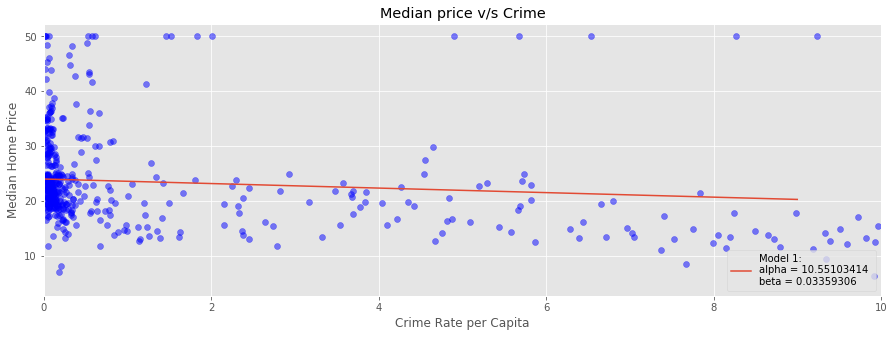

In [166]:
import statsmodels.api as sm

data = np.column_stack((bdata.data,bdata.target))

fit1 = smf.OLS(data[:,13], sm.add_constant(data[:,0])).fit()

# Your code here
x1 = np.array(range(0,10))
y1 = fit1.params[0] + fit1.params[1]*x1

plt.figure(figsize = (15,5))
scat = plt.scatter(data[:,0], data[:,13], color = 'blue', alpha = 0.5)
plt.xlim([-5,410])
model1, = plt.plot(x1, y1, linewidth = 1.5)

plt.legend([model1], ["Model 1: \nalpha = 10.55103414 \nbeta = 0.03359306"], 
                              
           loc = 4
          )
plt.xlim(0,10)
plt.xlabel('Crime Rate per Capita')
plt.ylabel('Median Home Price')
plt.title('Median price v/s Crime')
plt.show()

In [167]:
train = data[:333, :]

sk1 = sklearn.linear_model.LinearRegression()
model_fit = sk1.fit(train[:,5].reshape(-1,1), train[:,13].reshape(-1,1))

print "Train RMSE: " + str(np.sqrt(sum((train[:,[13]] - model_fit.predict(train[:,[5]]))**2)/333))
print "Test RMSE: " + str(np.sqrt(sum((data[333:,[13]] - model_fit.predict(data[333:,[5]]))**2)/333))


Train RMSE: [ 3.7879844]
Test RMSE: [ 7.60921272]


### 4.2 So many scatterplots!

Choose 8 out of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

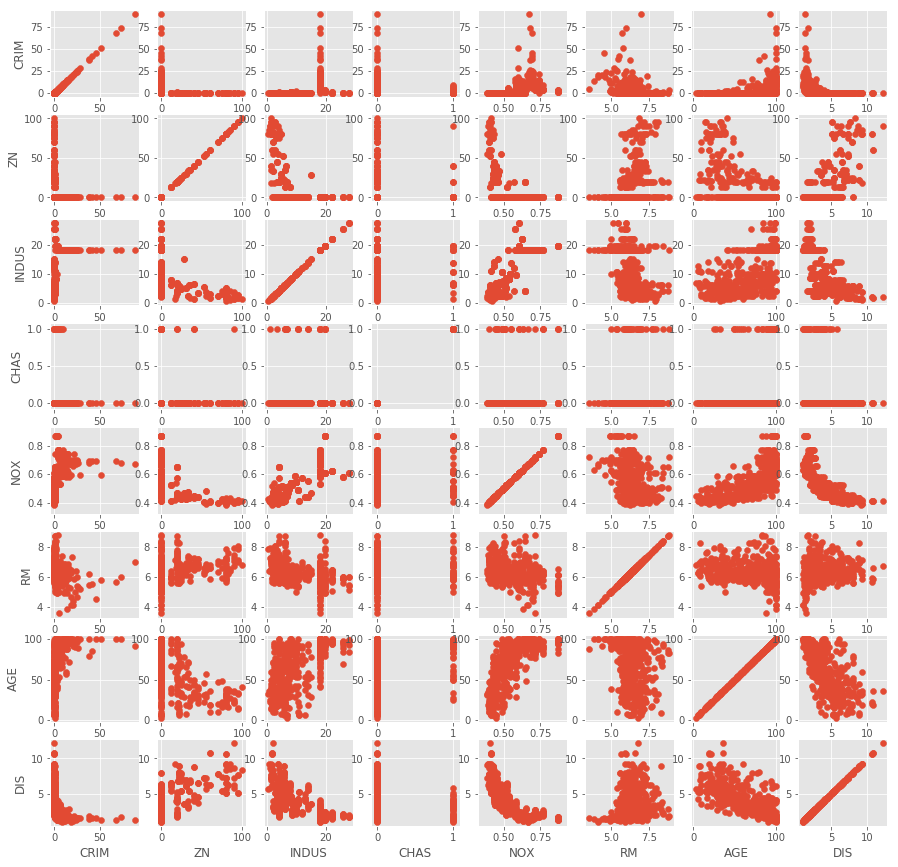

In [168]:
plt.figure(figsize=(15,15))
plt.title('Scatter plot showing relation between variables in Boston Housing Dataset')
for i in xrange(8):
    for j in xrange(8):
        plt.subplot(8, 8, i * 8 + j + 1)
        plt.scatter(bdata.data[:,j], bdata.data[:,i])
        plt.xlabel(bdata.feature_names[j])
        if j == 0:
            plt.ylabel(bdata.feature_names[i])

### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

/Users/amolsurve/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/amolsurve/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


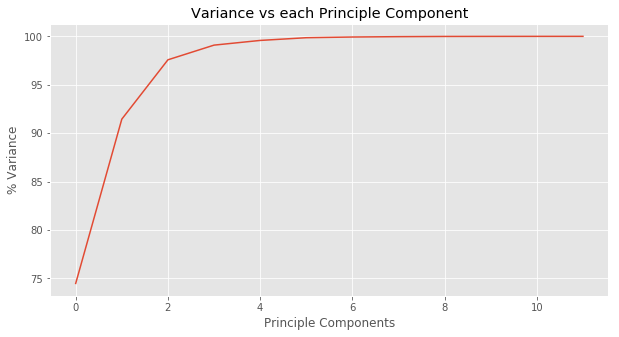

In [169]:
# Enter your code here
# Enter your code here
pca = PCA(12)
X_train = sklearn.preprocessing.normalize(bdata.data[:333,:])
X_test = sklearn.preprocessing.normalize(bdata.data[333:,:])
Y_train = sklearn.preprocessing.normalize(bdata.target[:333])
Y_test = sklearn.preprocessing.normalize(bdata.target[333:])

fitted_pca = pca.fit(X_train)

plt.figure(figsize = (10,5))
plot = plt.plot(range(0,12),fitted_pca.explained_variance_ratio_.cumsum()*100)
plt.xlabel('Principle Components')
plt.ylabel('% Variance')
plt.title('Variance vs each Principle Component')
plt.show()


### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

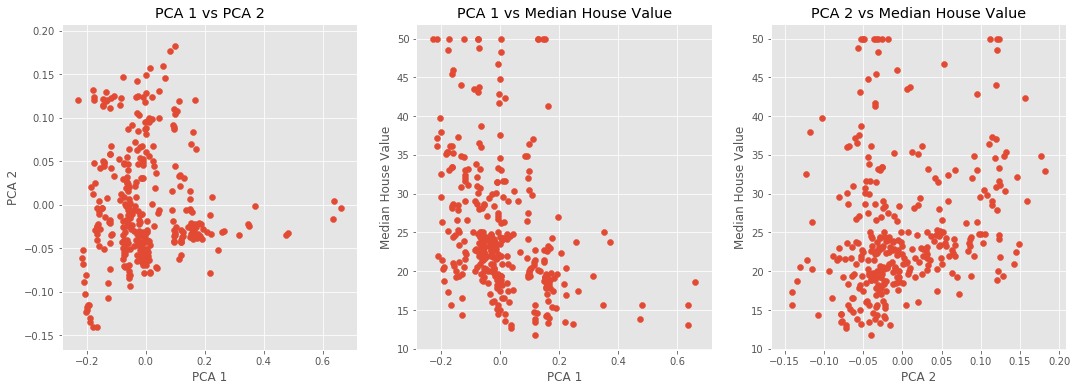

In [170]:
# Enter your code here
# Enter your code here
plt.figure(figsize=(18,6))
pca1 = pca.fit_transform(X_train)

plt.subplot(1, 3, 1)
plt.scatter(pca1[:, 0], pca1[:, 1])
plt.title('PCA 1 vs PCA 2')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 3, 2)
plt.scatter(pca1[:,0], bdata.target[:333])
plt.title('PCA 1 vs Median House Value')
plt.xlabel('PCA 1')
plt.ylabel('Median House Value')

plt.subplot(1, 3, 3)
plt.scatter(pca1[:,1], bdata.target[:333])
plt.title('PCA 2 vs Median House Value')
plt.xlabel('PCA 2')
plt.ylabel('Median House Value')

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [171]:
pcatrain = pca.fit_transform(X_train)
pcatest = pca.fit_transform(X_test)

pcatrain1 = pcatrain[:,0].reshape(-1, 1)
pcatest1 = pcatest[:,0].reshape(-1, 1)

ytrain = bdata.target[:333].reshape(-1,1)
ytest = bdata.target[333:].reshape(-1,1)



sk = sklearn.linear_model.LinearRegression()
model = sk.fit(pcatrain1, ytrain)
beta0 = sk.fit(pcatrain1, ytrain).intercept_
beta = sk.fit(pcatrain1, ytrain).coef_

rmsetrain = np.sqrt(sum((ytrain - model.predict(pcatrain1))**2/len(ytrain)))
rmsetest = np.sqrt(sum(np.square((ytest - model.predict(pcatest1)))/len(ytest)))
print "RMSE for train: " + str(rmsetrain)
print "RMSE for test: " + str(rmsetest)

RMSE for train: [ 8.02700678]
RMSE for test: [ 13.89677743]
